# Set-Up

In [132]:
import logging 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from sklearn.metrics import pairwise_distances

In [133]:
logging.basicConfig(filename='../debug_info.log', encoding='utf-8', level=logging.DEBUG)

# Fetch data

In [134]:
initial_data_url = "https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6"
final_data_url = "https://data.mendeley.com/datasets/kg72dst75p/1"

In [135]:
data_1day = pd.read_csv("../data/Coronavirus_Data_Cases_1a. Per day.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_1date = pd.read_csv("../data/Coronavirus_Data_Cases_1b. Per date.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2day = pd.read_csv("../data/Coronavirus_Data_Cases_2a. Per day_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2date = pd.read_csv("../data/Coronavirus_Data_Cases_2b. Per date_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5date = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per date_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5day = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per day_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')

# Cleaning Data
## Adjust Data types and columns

In [136]:
def clean_up(dataframe):

    dataframe.dropna(axis=1, how='all', inplace=True)
    dataframe = dataframe.apply(pd.to_numeric, args={'coerce'})
    #TODO Why do we need this part?
    # dataframe.columns = [col.replace('United Kingdom', 'UK') for col in dataframe.columns]

    if type(dataframe.index[0])  == str and ('density'.title() in dataframe.index[0]  or 'population'.title() in dataframe.index[0]):

        if '/' not in dataframe.index[1]:

            dataframe_with_metric = dataframe.iloc[0].T.squeeze()
            dataframe = dataframe.iloc[1:].copy()
            dataframe_with_metric.name = 'Day'
            dataframe.index = dataframe.index.astype(int)
            dataframe.index.name = 'Day'
            return (dataframe, dataframe_with_metric)
        
        elif '/' in dataframe.index[1]:

            dataframe_with_metric = dataframe.iloc[0].T.squeeze()
            dataframe_with_metric.name = 'Date'
            dataframe = dataframe.iloc[1:].copy()
            dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
            dataframe.index.name = 'Date'
            return (dataframe, dataframe_with_metric)
    
    elif type(dataframe.index[0])  == str and '/' in dataframe.index[1]:

        if np.nan in dataframe.index:

            dataframe = dataframe.iloc[:-5].copy()
            dataframe_metric = dataframe.iloc[-4:].copy()
            dataframe_metric.index.name = 'Date'
            dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
            dataframe.index.name = 'Date'
            return dataframe, dataframe_metric
        
        else:
            
            dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
            dataframe.index.name = 'Date'
            return dataframe
    else: # type index = int
        
        dataframe.index.name = 'Day'
        return dataframe


data_1day = clean_up(data_1day)
#TODO The data_1date_metrics does not really make sense to me - Do we have to adjust that?
data_1date, data_1date_metrics = clean_up(data_1date)
data_2day, data_2day_population = clean_up(data_2day)
data_2date, data_2date_population = clean_up(data_2date)
data_5date, data_5date_density = clean_up(data_5date)
data_5day, data_5day_density = clean_up(data_5day)

## Trying the 4 steps algorithm 
- step 1: no code
- step 2: Calculate all the rates of change for every pair xj{ti}, xj{ti+1}, and find number of day kj when for the first time rate appears to be larger than 20% of the mean value of previous initial rates (that are always small in our time series).
- step 3: For all time series xj{ti} keep terms from i=k...m where k minimum of all kj.
- step 4: Run the agglomerative clustering algorithm with single/complete linkage and Eu-
clidean distance.

### Step 1: Flattening Regime calculation

In [137]:
def new_cases(data):
    df_new_cases = data.copy()
    df_new_cases[1:] -= np.array(data[:-1])
    return df_new_cases

In [138]:
new_cases_1date = new_cases(data_1date)
new_cases_2date = new_cases(data_2date)
new_cases_5date = new_cases(data_5date)

new_cases_1day = new_cases(data_1day)
new_cases_2day = new_cases(data_2day)
new_cases_5day = new_cases(data_5day)

In [139]:
def cut_flattening(data):
    data = new_cases(data)
    flattening_detector = lambda df: df.iloc[:7].mean() < df.iloc[7:].mean() 
    temp = data.rolling(window=10).apply(flattening_detector)
    temp = temp.expanding().sum() > 0
    data[temp] = pd.NA
    return data

cutted_1date = cut_flattening(data_1date)

### Step 2

In [140]:
data_1day_pct_change = data_1day.pct_change().iloc[1:]
data_1day_pct_change


,US,"Korea, South",China,Taiwan*,Thailand,Japan,Vietnam,Singapore,France,Nepal,...,Anguilla-United Kingdom,British Virgin Islands-United Kingdom,Turks and Caicos Islands-United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone,"Bonaire, Sint Eustatius and Saba-Netherlands",Malawi,Falkland Islands (Islas Malvinas)-United Kingdom
Day,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.000000,0.173358,0.000000,0.500000,0.000000,0.000000,2.000000,0.500000,0.0,...,0.0,0.0,0.000000,0.0,0.333333,0.0,1.0,0.0,0.000000,0.0
3,1.000000,1.000000,0.430793,2.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.250000,0.0,0.000000,0.5,0.0,0.0,0.333333,0.0
4,0.000000,0.000000,0.528261,0.000000,0.400000,0.000000,0.000000,0.333333,0.000000,0.0,...,0.0,0.5,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
5,1.500000,0.500000,0.475818,0.333333,0.142857,1.000000,0.000000,0.250000,0.333333,0.0,...,0.0,0.0,0.200000,3.5,0.000000,0.0,1.0,0.0,0.000000,0.0
6,0.000000,0.333333,0.386506,0.250000,0.000000,0.000000,0.000000,0.400000,0.250000,0.0,...,0.5,0.0,-0.166667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.162941,0.012939,0.000985,0.052288,0.083333,0.046624,0.028302,0.079914,0.037130,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
71,0.133920,0.010321,0.000997,0.021739,0.072683,0.115207,0.068807,0.049000,0.088537,0.5,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
72,0.140979,0.009002,0.000862,0.030395,0.058724,0.145546,0.017167,0.061964,0.398132,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [141]:
data_1day_pct_change_accumulative_avg = data_1day_pct_change.expanding().mean()
data_1day_pct_change_accumulative_avg.head(5)

,US,"Korea, South",China,Taiwan*,Thailand,Japan,Vietnam,Singapore,France,Nepal,...,Anguilla-United Kingdom,British Virgin Islands-United Kingdom,Turks and Caicos Islands-United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone,"Bonaire, Sint Eustatius and Saba-Netherlands",Malawi,Falkland Islands (Islas Malvinas)-United Kingdom
Day,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.000000,0.173358,0.000000,0.500000,0.00,0.0,2.000000,0.500000,0.0,...,0.0,0.000000,0.000000,0.000,0.333333,0.000000,1.000000,0.0,0.000000,0.0
3,0.500000,0.500000,0.302075,1.000000,0.583333,0.00,0.0,1.000000,0.250000,0.0,...,0.0,0.000000,0.125000,0.000,0.166667,0.250000,0.500000,0.0,0.166667,0.0
4,0.333333,0.333333,0.377471,0.666667,0.522222,0.00,0.0,0.777778,0.166667,0.0,...,0.0,0.166667,0.083333,0.000,0.111111,0.166667,0.333333,0.0,0.111111,0.0
5,0.625000,0.375000,0.402057,0.583333,0.427381,0.25,0.0,0.645833,0.208333,0.0,...,0.0,0.125000,0.112500,0.875,0.083333,0.125000,0.500000,0.0,0.083333,0.0
6,0.500000,0.366667,0.398947,0.516667,0.341905,0.20,0.0,0.596667,0.216667,0.0,...,0.1,0.100000,0.056667,0.700,0.066667,0.100000,0.400000,0.0,0.066667,0.0


In [142]:
data_1day_pct_change > data_1day_pct_change_accumulative_avg * 0.2 

,US,"Korea, South",China,Taiwan*,Thailand,Japan,Vietnam,Singapore,France,Nepal,...,Anguilla-United Kingdom,British Virgin Islands-United Kingdom,Turks and Caicos Islands-United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone,"Bonaire, Sint Eustatius and Saba-Netherlands",Malawi,Falkland Islands (Islas Malvinas)-United Kingdom
Day,,,,,,,,,,,,,,,,,,,,,
2,False,False,True,False,True,False,False,True,True,False,...,False,False,False,False,True,False,True,False,False,False
3,True,True,True,True,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False
4,False,False,True,False,True,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
5,True,True,True,True,True,True,False,True,True,False,...,False,False,True,True,False,False,True,False,False,False
6,False,True,True,True,False,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,True,False,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
71,True,False,False,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
72,True,False,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [143]:
len(data_1day.columns)

207

## Plotting gradients of 8 countries

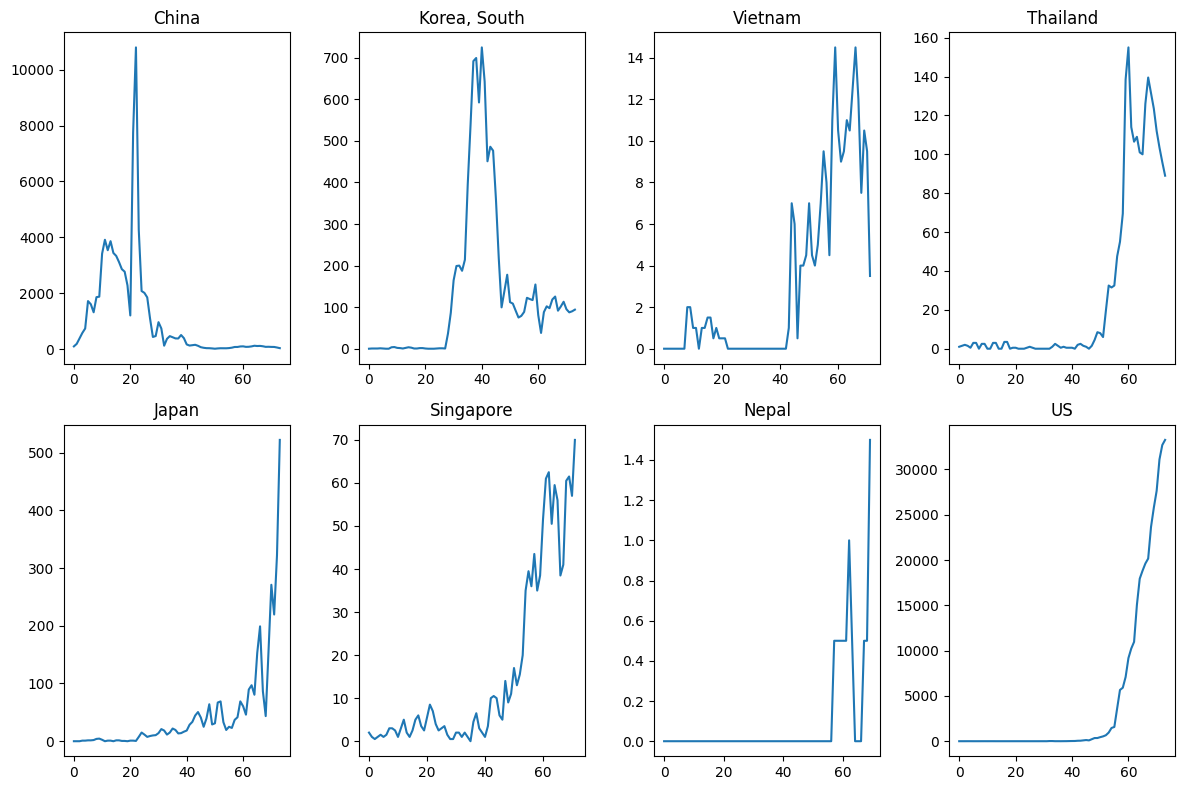

In [144]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

prova = data_1day[['China', 'Korea, South', 'Vietnam', 'Thailand', 'Japan', 'Singapore', 'Nepal', 'US']]
for i, country in enumerate(prova.columns):
    ax = axes.flat[i]
    ax.plot(np.gradient(data_1day[country]))
    ax.set_title(country)

# Show the plot
plt.tight_layout()
plt.show()


# Visualizations (Cases per Day)
## Choose relevant columns - truncating data

In [145]:
def truncate_date(data_date):
    last_day = data_date.loc['04/04/2020']
    last_day = last_day.sort_values(ascending=False)
    last_day = last_day[:30]
    data_date = data_date[last_day.index]
    return data_date

def truncate_day(data_day, data_date):
    data_day = data_day.copy()
    columns = list(set(data_day.columns) & set(data_date.columns))
    first_occ = data_date[columns] > 0 
    first_occ = first_occ.apply(pd.Series.idxmax)
    first_occ = first_occ.sort_values(ascending = True)
    first_occ = first_occ[:30]
    data_day = data_day[first_occ.index] 
    return data_day

data_1date_trunc = truncate_date(data_1date) 
data_2date_trunc = truncate_date(data_2date)
data_5date_trunc = truncate_date(data_5date)
data_1day_trunc = truncate_day(data_1day, data_1date)   
data_2day_trunc = truncate_day(data_2day, data_2date)
data_5day_trunc = truncate_day(data_5day, data_5date)

## Plot Cases

### Absolute cases

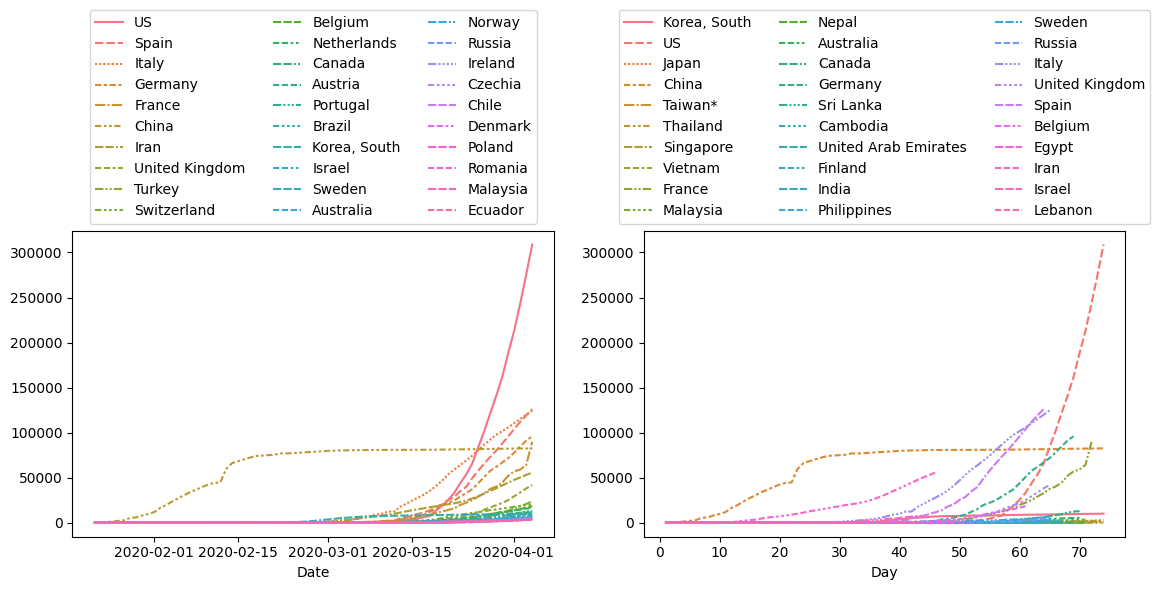

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=data_1date_trunc, ax=ax1)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

sns.lineplot(data=data_1day_trunc, ax=ax2)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

plt.tight_layout()
plt.show()


### Cases per 1 million

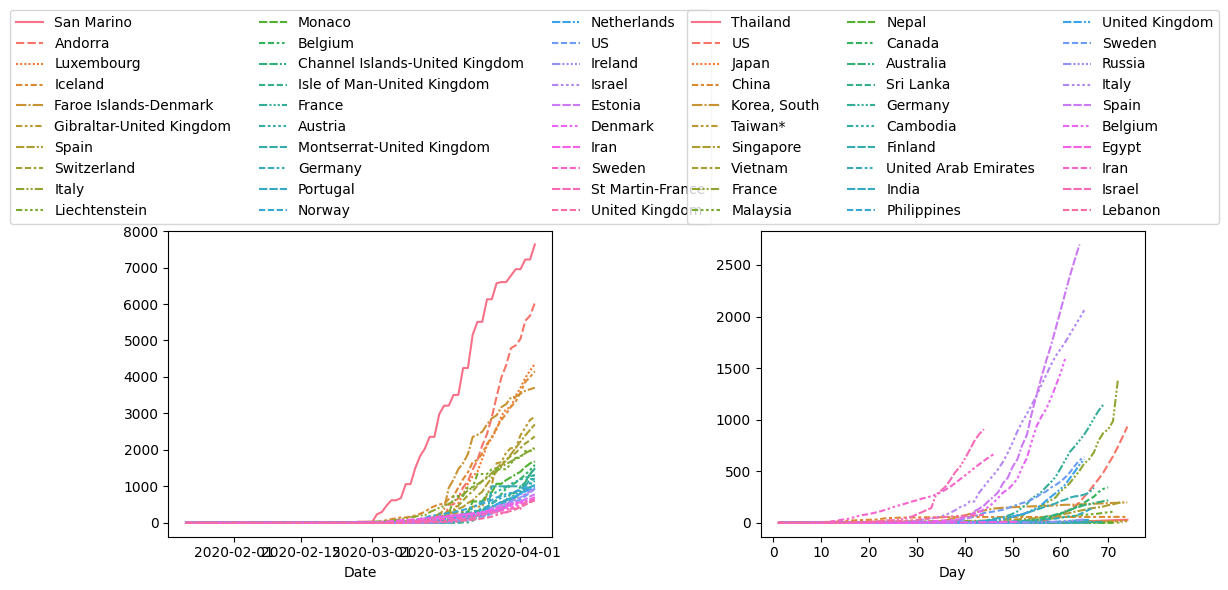

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=data_2date_trunc, ax=ax1)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

sns.lineplot(data=data_2day_trunc, ax=ax2)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

plt.tight_layout()
plt.show()
#TODO fix positions and number of columns legend

### Cases per population per land

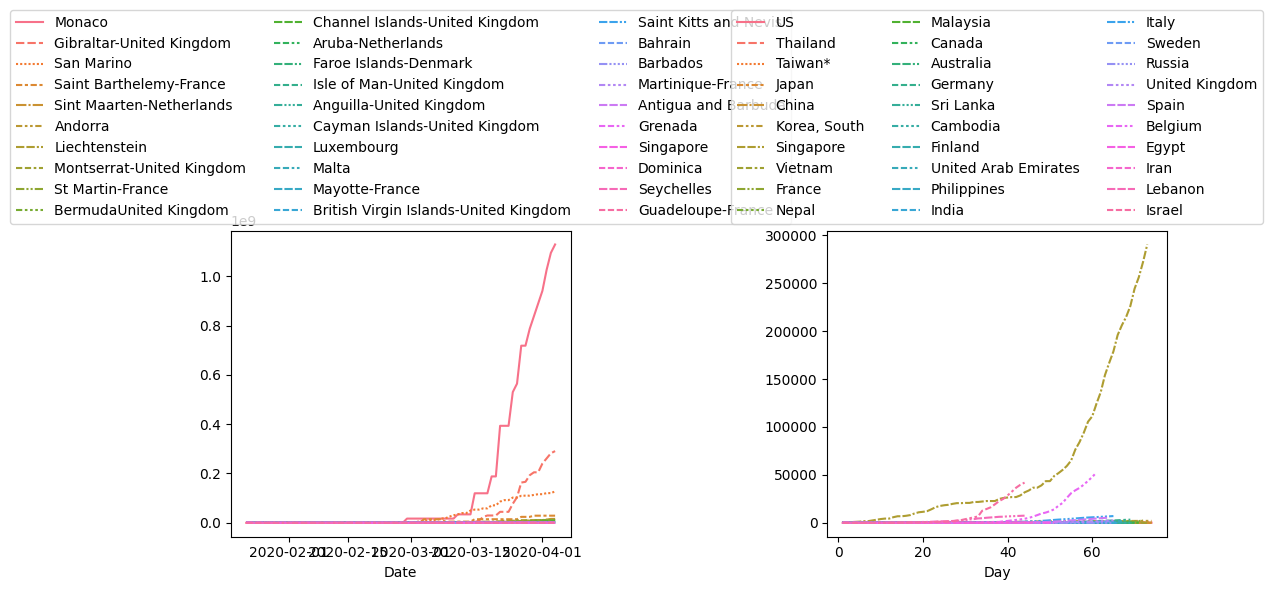

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=data_5date_trunc, ax=ax1)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

sns.lineplot(data=data_5day_trunc, ax=ax2)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

plt.tight_layout()
plt.show()

# Agglomerative Clustering

In [149]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [150]:
def plot_hierarchy(data, ax):
    data = data.transpose()
    linkage_matrix = linkage(data, method='single', metric='euclidean')
    R = dendrogram(linkage_matrix, no_plot=True)
    plt.draw()

    country_names = data.index.to_list()
    temp = {R['leaves'][i]: country_names[i] for i in range(len(R['leaves']))}
    def llf(i):
        return '{}---{}'.format(temp[i], i)

    dendrogram(
        linkage_matrix
        , ax=ax
        , orientation='right'
        , leaf_label_func=llf
    )
    ax.set_xticks([])

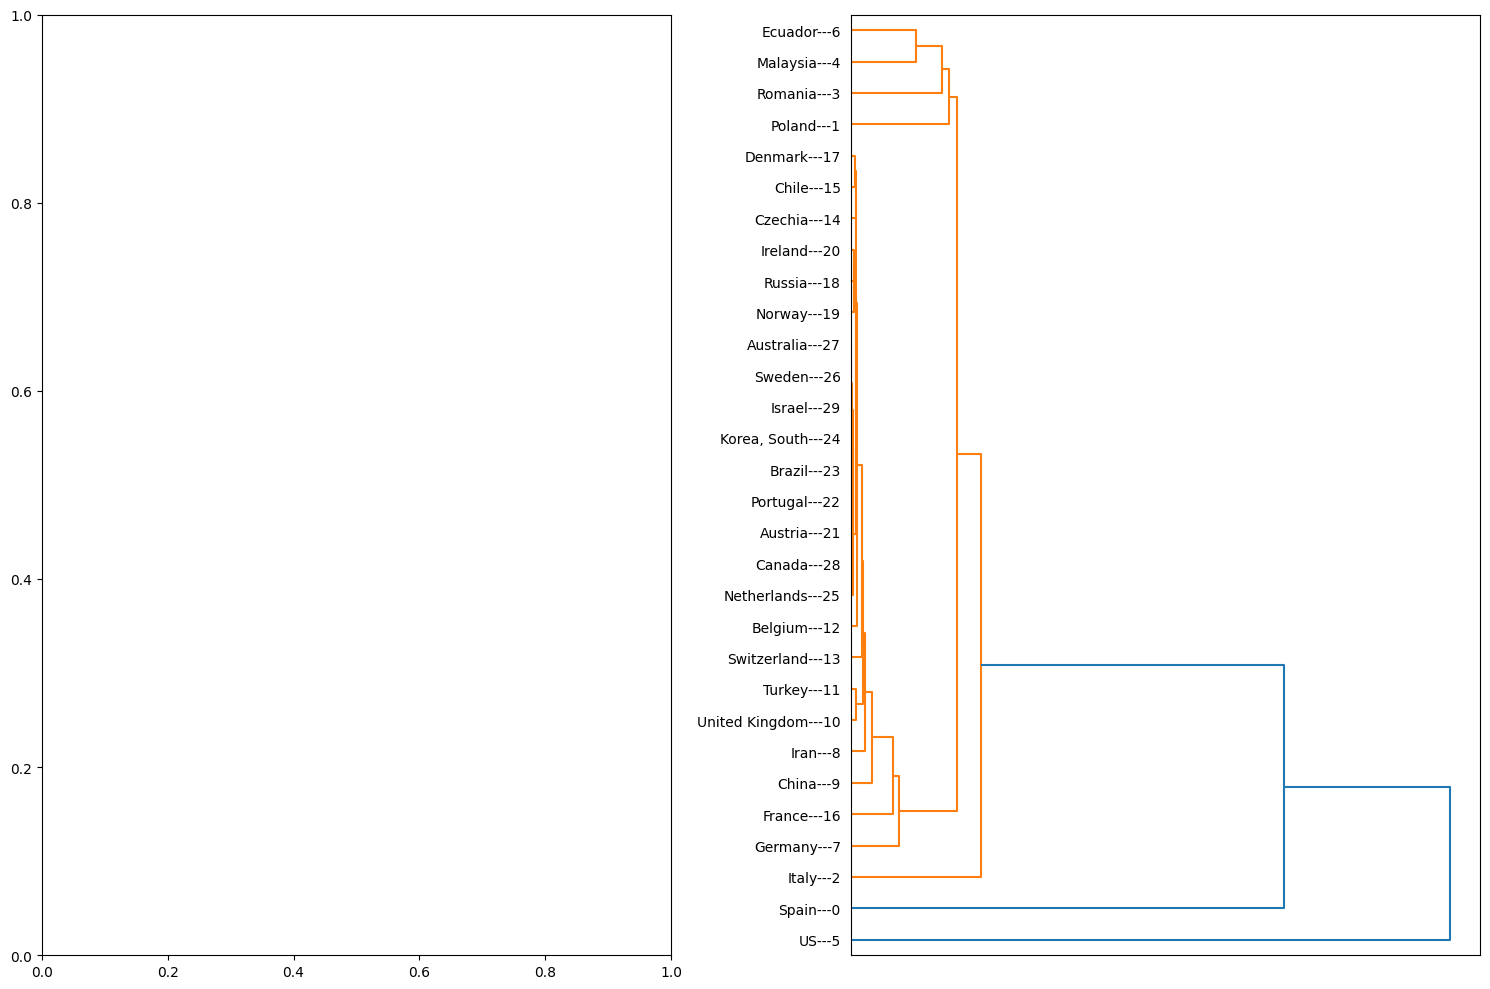

In [152]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=2)

#FIXME Infinite values cause a problem in the day datasets
# plot_hierarchy(data_1day_trunc, ax=axes[0])
plot_hierarchy(data_1date_trunc, ax=axes[1])

fig.tight_layout()

plt.savefig('../figures/Clustering1')

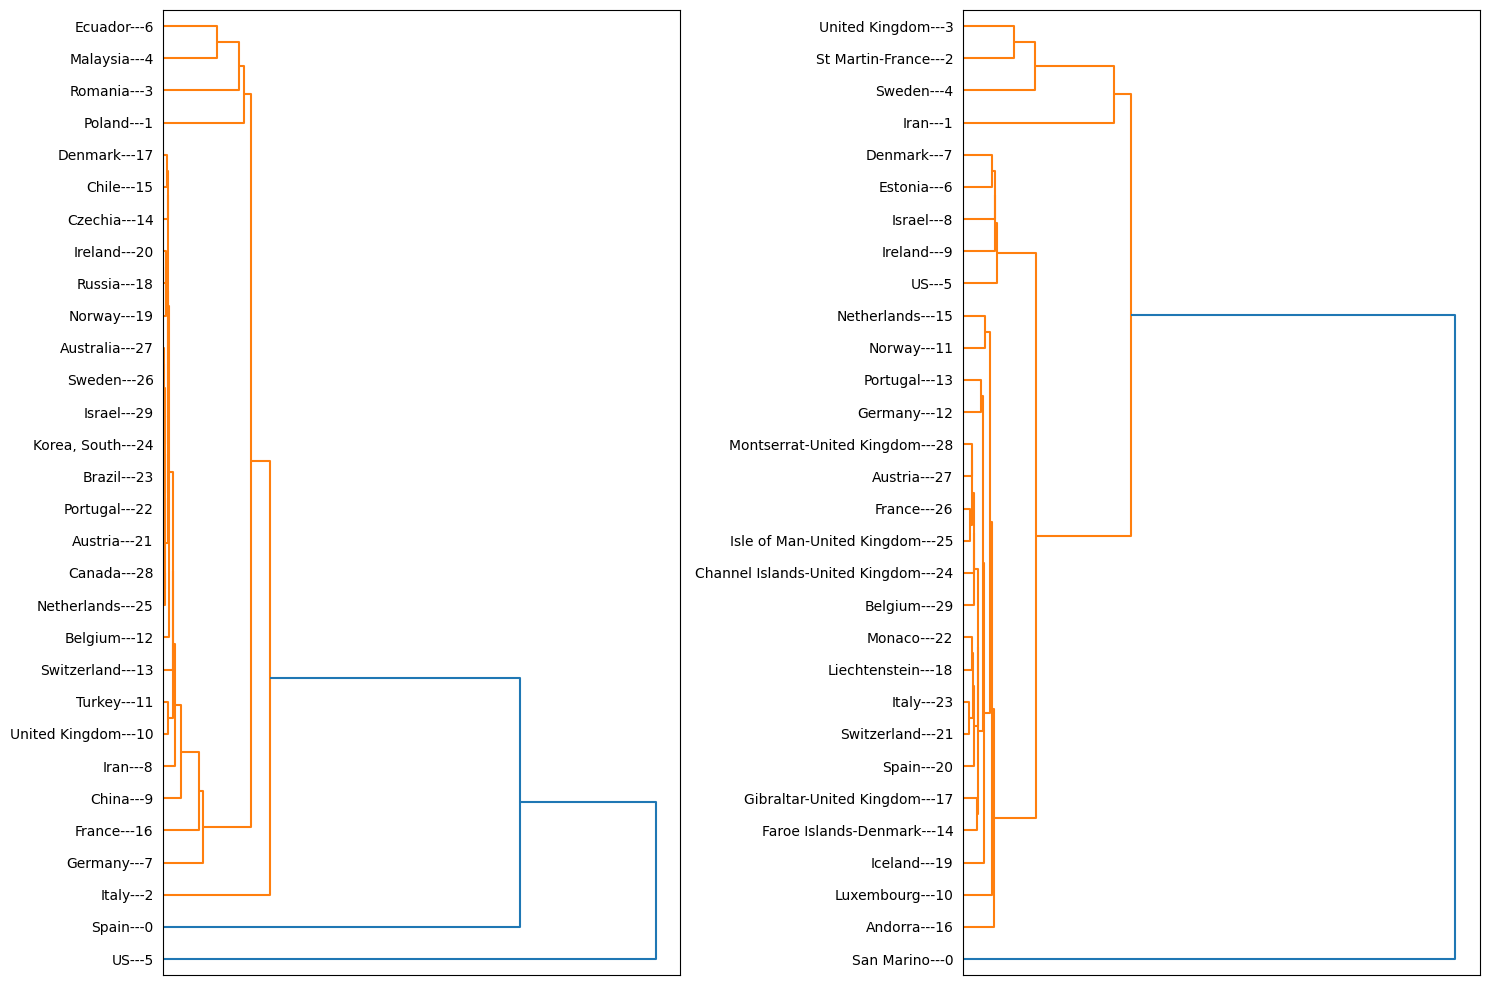

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=2)

# plot_hierarchy(data_2day_trunc, ax=axes[0])
plot_hierarchy(data_2date_trunc, ax=axes[1])

fig.tight_layout()

plt.savefig('../figures/Clustering1')